# Integrative analysis of ATAC & RNA - Processing, integration and differential analysis
- goal: filtered, normalized and batch corrected data + DEA results
- input: raw counts
- output: filtered and normalized counts, batch corrected counts, DEA results

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(limma)
library(data.table, quietly=T)
library(edgeR)
library(ggplot2)
library(gplots)
library(pheatmap)
options(stringsAsFactors=F)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [3]:
# util function

# Rotate x-axis in ggplot
xRot <- function(){theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))}

# Make a matrix out of a data.table
toMT <- function(dt, row, col, val){
  retDT <- dcast.data.table(dt, get(row) ~ get(col), value.var=val)
  retMT <- as.matrix(retDT[,-"row"])
  row.names(retMT) <- retDT$row
  return(retMT)
}

# Remove plots from device. Useful for pheatmap (and others?)
cleanDev <- function(n=2){sapply(1:n, function(i){try({dev.off()}, silent=TRUE)}); return(TRUE)}

In [4]:
# configs
data_path_atac <- file.path('results','ATAC','all')
data_path_rna <- file.path('results','RNA','counts')
results_path <- file.path('results','INT')

In [5]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# Load data

## annotations

In [6]:
# load ATAC annotations
annot_atac <- read.csv(file=file.path('metadata','ATAC_sample_metadata.csv'), row.names=1)
dim(annot_atac)
head(annot_atac)

[1] 78 10

,library,timepoint.after.thawing,cell_line,Treatment,Treatment_time,mouse_pool,sex,bio.replicate,organism,experiment_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PT76_R1_C_albicans_2h,ATAC-seq,d010,BMDM,C_albicans,2h,PT62_c,female,R1,mouse,PT76
PT76_R1_C_albicans_4h,ATAC-seq,d010,BMDM,C_albicans,4h,PT62_c,female,R1,mouse,PT76
PT76_R1_C_albicans_6h,ATAC-seq,d010,BMDM,C_albicans,6h,PT62_c,female,R1,mouse,PT76
PT76_R1_C_albicans_8h,ATAC-seq,d010,BMDM,C_albicans,8h,PT62_c,female,R1,mouse,PT76
PT76_R1_untreated_0h,ATAC-seq,d010,BMDM,untreated,0h,PT62_c,female,R1,mouse,PT76
PT76_R1_IFN_beta_2h,ATAC-seq,d010,BMDM,IFN_beta,2h,PT62_c,female,R1,mouse,PT76


In [7]:
# load RNA annotations
annot_rna <- read.csv(file=file.path('metadata','RNA_sample_metadata.csv'), row.names=1)
dim(annot_rna)
head(annot_rna)

[1] 66 10

,library,timepoint.after.thawing,cell_line,Treatment,Treatment_time,mouse_pool,sex,organism,bio.replicate,experiment_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
RNA_PT76_R1_C_albicans_2h,Quant-seq,d010,BMDM,C_albicans,2h,PT62_c,female,mouse,R1,PT76
RNA_PT82_R1_C_albicans_24h,Quant-seq,d010,BMDM,C_albicans,24h,PT62_c,female,mouse,R1,PT82
RNA_PT76_R1_C_albicans_4h,Quant-seq,d010,BMDM,C_albicans,4h,PT62_c,female,mouse,R1,PT76
RNA_PT76_R1_C_albicans_6h,Quant-seq,d010,BMDM,C_albicans,6h,PT62_c,female,mouse,R1,PT76
RNA_PT82_R1_C_albicans_8h,Quant-seq,d010,BMDM,C_albicans,8h,PT62_c,female,mouse,R1,PT82
RNA_PT76_R1_untreated_0h,Quant-seq,d010,BMDM,untreated,0h,PT62_c,female,mouse,R1,PT76


In [8]:
# concatenate annotations
annot <- rbind(annot_rna, annot_atac)
dim(annot)
head(annot)

[1] 144  10

,library,timepoint.after.thawing,cell_line,Treatment,Treatment_time,mouse_pool,sex,organism,bio.replicate,experiment_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
RNA_PT76_R1_C_albicans_2h,Quant-seq,d010,BMDM,C_albicans,2h,PT62_c,female,mouse,R1,PT76
RNA_PT82_R1_C_albicans_24h,Quant-seq,d010,BMDM,C_albicans,24h,PT62_c,female,mouse,R1,PT82
RNA_PT76_R1_C_albicans_4h,Quant-seq,d010,BMDM,C_albicans,4h,PT62_c,female,mouse,R1,PT76
RNA_PT76_R1_C_albicans_6h,Quant-seq,d010,BMDM,C_albicans,6h,PT62_c,female,mouse,R1,PT76
RNA_PT82_R1_C_albicans_8h,Quant-seq,d010,BMDM,C_albicans,8h,PT62_c,female,mouse,R1,PT82
RNA_PT76_R1_untreated_0h,Quant-seq,d010,BMDM,untreated,0h,PT62_c,female,mouse,R1,PT76


In [9]:
# rename columns
names(annot)[names(annot) == 'Treatment'] <- 'treatment'
names(annot)[names(annot) == 'Treatment_time'] <- 'time'
names(annot)[names(annot) == 'experiment_id'] <- 'experiment'

In [10]:
# remove QC'd samples & unused columns
annot <- annot[(rownames(annot)!='RNA_PT82_R1_untreated_8h') & (rownames(annot)!='RNA_PT82_R1_LPS_24h'),]
annot[,c('timepoint.after.thawing','cell_line', 'mouse_pool', 'sex', 'organism', 'bio.replicate')] <- NULL

In [11]:
# modify time annotations of untreated samples
annot[annot$treatment=='untreated','time'] <- '0h'

In [12]:
# add group column for DEA
annot$group <- with(annot, paste(treatment, time, sep="_"))

In [13]:
annot$library <- factor(annot$library, levels = unique(annot$library))

In [14]:
# save annotations
write.table(annot, file.path(results_path, 'INT_annotations.csv') ,sep=",", row.names=TRUE, quote=FALSE)

## count data

In [15]:
# load RNA data
data_rna <- read.csv(file=file.path(data_path_rna, 'all.tsv'), row.names=1, sep='\t')
data_rna <- data_rna[,rownames(annot)[annot$library=='Quant-seq']]
dim(data_rna)
head(data_rna)

[1] 55487    64

,RNA_PT76_R1_C_albicans_2h,RNA_PT82_R1_C_albicans_24h,RNA_PT76_R1_C_albicans_4h,RNA_PT76_R1_C_albicans_6h,RNA_PT82_R1_C_albicans_8h,RNA_PT76_R1_untreated_0h,RNA_PT82_R1_untreated_24h,RNA_PT76_R1_IFN_beta_2h,RNA_PT82_R1_IFN_beta_24h,RNA_PT76_R1_IFN_beta_4h,⋯,RNA_PT76_R2_LO28_2h,RNA_PT82_R2_LO28_24h,RNA_PT76_R2_LO28_4h,RNA_PT76_R2_LO28_6h,RNA_PT82_R2_LO28_8h,RNA_PT76_R2_LPS_2h,RNA_PT82_R2_LPS_24h,RNA_PT76_R2_LPS_4h,RNA_PT76_R2_LPS_6h,RNA_PT82_R2_LPS_8h
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000102851,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [16]:
# load ATAC data
data_atac <- read.csv(file=file.path(data_path_atac,'promoter_counts.csv'), row.names=1)
dim(data_atac)
head(data_atac)

[1] 55487    78

,PT76_R1_C_albicans_2h,PT76_R1_C_albicans_4h,PT76_R1_C_albicans_6h,PT76_R1_C_albicans_8h,PT76_R1_untreated_0h,PT76_R1_IFN_beta_2h,PT76_R1_IFN_beta_4h,PT76_R1_IFN_beta_6h,PT76_R1_IFN_beta_8h,PT76_R1_IFN_gamma_2h,⋯,PT82_R2_IFN_gamma_24h,PT82_R2_IFN_gamma_8h,PT82_R2_LCMV_Cl13_24h,PT82_R2_LCMV_Cl13_8h,PT82_R2_LO28_24h,PT82_R2_LO28_8h,PT82_R2_LPS_24h,PT82_R2_LPS_8h,PT82_R2_untreated_24h,PT82_R2_untreated_8h
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693,3,7,0,5,3,3,2,1,0,2,⋯,3,5,2,3,14,5,1,6,6,9
ENSMUSG00000064842,2,3,8,1,1,5,3,2,3,5,⋯,2,2,1,2,11,1,3,3,5,12
ENSMUSG00000051951,8,11,5,11,7,10,5,2,4,13,⋯,6,8,5,7,22,9,6,4,10,17
ENSMUSG00000102851,3,8,2,7,5,6,5,4,2,7,⋯,7,14,7,6,41,16,9,17,5,11
ENSMUSG00000103377,4,3,2,4,5,1,5,2,4,9,⋯,4,10,3,5,11,7,7,5,9,8
ENSMUSG00000104017,1,5,3,6,1,2,1,3,0,9,⋯,1,8,5,4,10,6,5,4,3,11


# Determine relevant features, filter data and concatenate

In [17]:
# load filtered RNA data
data_rna_filtered <- read.csv(file=file.path(data_path_rna, 'all_filtered.tsv'), row.names=1, sep='\t')
rna_genes <- rownames(data_rna_filtered)
length(rna_genes)

[1] 12729

In [18]:
# filter genes in ATAC with edgeR
keep_atac_genes <- filterByExpr(data_atac, group=annot$group)
atac_genes <- rownames(data_atac)[keep_atac_genes]
length(atac_genes)

[1] 44628

In [19]:
genes_filtered <- union(rna_genes, atac_genes)
length(genes_filtered)

[1] 45069

In [20]:
data <- cbind(data_rna[genes_filtered,], data_atac[genes_filtered,])
dim(data)
head(data)

[1] 45069   142

,RNA_PT76_R1_C_albicans_2h,RNA_PT82_R1_C_albicans_24h,RNA_PT76_R1_C_albicans_4h,RNA_PT76_R1_C_albicans_6h,RNA_PT82_R1_C_albicans_8h,RNA_PT76_R1_untreated_0h,RNA_PT82_R1_untreated_24h,RNA_PT76_R1_IFN_beta_2h,RNA_PT82_R1_IFN_beta_24h,RNA_PT76_R1_IFN_beta_4h,⋯,PT82_R2_IFN_gamma_24h,PT82_R2_IFN_gamma_8h,PT82_R2_LCMV_Cl13_24h,PT82_R2_LCMV_Cl13_8h,PT82_R2_LO28_24h,PT82_R2_LO28_8h,PT82_R2_LPS_24h,PT82_R2_LPS_8h,PT82_R2_untreated_24h,PT82_R2_untreated_8h
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000098104,1,6,0,2,1,9,4,6,4,0,⋯,8,7,3,11,31,14,5,12,10,9
ENSMUSG00000033845,219,220,201,169,196,204,226,202,124,153,⋯,210,109,218,185,32,164,127,155,156,123
ENSMUSG00000025903,115,105,106,113,87,144,128,159,98,137,⋯,366,204,351,328,65,192,282,150,255,205
ENSMUSG00000033813,63,57,39,74,51,53,68,58,63,124,⋯,701,414,674,625,113,424,459,357,550,485
ENSMUSG00000033793,315,222,309,250,312,203,277,266,222,218,⋯,0,5,6,4,12,6,3,5,4,9
ENSMUSG00000025907,295,355,225,280,225,285,336,169,354,166,⋯,45,21,18,31,21,26,15,13,36,35


In [21]:
# save raw count data
write.table(data, file.path(results_path, 'INT_counts.csv') ,sep=",", row.names=TRUE, quote=FALSE)

# Normalize, batch correct for assay and DEA

In [22]:
# structural immunity paper -> old
# designMT <- model.matrix(data=annot, ~ 0 + group / library)

# batch/experiment correction like in the modality-wise analysis
designMT <- model.matrix(data=annot, ~ 0 + group / library + experiment)
# lm(y ~ x/z, data) is a shortcut for lm(y ~ x + x:z, data)

In [24]:
stopifnot(all(row.names(annot) == colnames(data)))

In [25]:
voomMT <- voom(counts=data, design=designMT, normalize.method="quantile")

In [26]:
# save normalized data
write.table(voomMT$E, file.path(results_path, 'INT_norm.csv') ,sep=",", row.names=TRUE, quote=FALSE)

In [28]:
# remove batch and protect signal
voomMT$E <- removeBatchEffect(voomMT$E, 
                              covariates=model.matrix(data=annot, ~ library)[,2,drop=F], 
                              design=model.matrix(data=annot, ~ 0 + group + experiment))

In [29]:
# save normalized and batch corrected data
write.table(voomMT$E, file.path(results_path, 'INT_norm_batchCorrected.csv') ,sep=",", row.names=TRUE, quote=FALSE)

In [30]:
# DEA
fit <- lmFit(voomMT, designMT)
fit <- eBayes(fit)

In [31]:
# save normalized and batch corrected & fitted data -> seems to be the same as batch corrected
vMT.norm <- voomMT$E
# write.table(vMT.norm, file.path(results_path, 'INT_norm_batchCorrected_fitted.csv') ,sep=",", row.names=TRUE, quote=FALSE)

In [32]:
# vMT.norm <- voomMT$E

In [33]:
# make directories if not exist
dir.create(file.path(results_path, "DEA"), showWarnings = FALSE)

In [34]:
# plot fitted mean/variance relationship
pdf(file.path(results_path,'DEA', "Voom_fitted.pdf"))
plotSA(fit)
dev.off()

png 
  2

In [35]:
# check spearman correlation between normalized and fitted RNA & ATAC mean expression/intensities
cor(rowMeans(vMT.norm[,rownames(annot)[annot$library=='Quant-seq']]), rowMeans(vMT.norm[,rownames(annot)[annot$library=='ATAC-seq']]), method="spearman")

[1] 0.949928

In [36]:
# check pearson correlation between normalized and fitted RNA & ATAC mean expression/intensities
cor(rowMeans(vMT.norm[,rownames(annot)[annot$library=='Quant-seq']]), rowMeans(vMT.norm[,rownames(annot)[annot$library=='ATAC-seq']]), method="pearson")

[1] 0.999962

In [38]:
# get coefficients per group (ie treatment + time)
coefss <- grep(":libraryATAC-seq", colnames(coef(fit)), value=T)
res <- data.table()
for(coefx in coefss){
  treatmentx <- gsub("group(.+)_(.+)\\:library.+", "\\1", coefx)
  timex <- gsub("group(.+)_(.+)\\:library.+", "\\2", coefx)
  res <- rbind(res, data.table(topTable(fit, coef=coefx, number=nrow(data)), keep.rownames=T, time = timex, treatment = treatmentx))
}
res[,group := paste0(treatment,'_', time)]

In [45]:
# save results
write.table(res, file.path(results_path, 'DEA', 'INT_DEA_all.csv') ,sep=",", row.names=FALSE, quote=FALSE)

In [55]:
# save DEA results per condition
for (tmp_treatment in unique(annot$treatment)){
    write.table(res[res$treatment==tmp_treatment,], file.path(results_path, 'DEA', paste0('INT_DEA_',tmp_treatment,".csv")) , sep=",", row.names=FALSE, quote=FALSE)
}

# plot results and sanity checks

In [57]:
res.sig <- res[adj.P.Val < 0.05] # filter only significant regions
res.sig[,direction := ifelse(logFC > 0, "potential", "abundance")]

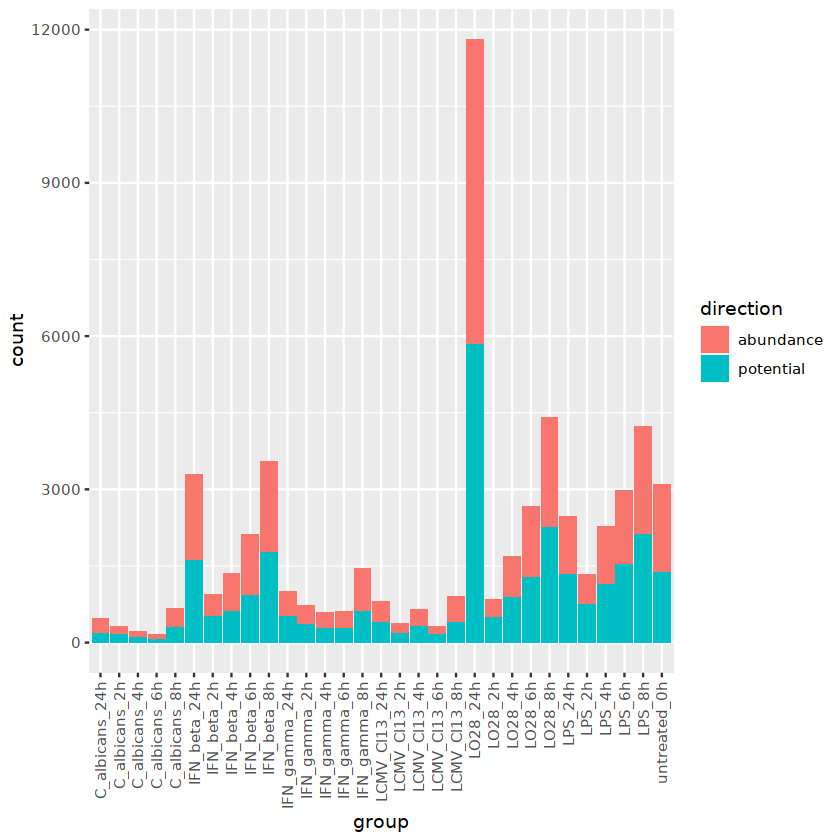

In [58]:
# plot number of significant hits
ggplot(res.sig, aes(x=group, fill=direction)) + geom_bar() + xRot()
ggsave(file.path(results_path, 'DEA',  "NumberOfHits.pdf"), w=10,h=5)

In [59]:
# CONTROL PLOTS FOR P value distributions
res[, AveExprBin := as.character(pmin(floor(AveExpr),5))]

quantile(res$logFC)

dir.create(file.path(results_path, 'DEA', "pvalueDistr"))
for(grp in unique(res$group)){
  ggplot(res[group==grp], aes(x= .bincode(P.Value, breaks=seq(0,1,0.05)), fill=AveExprBin)) + geom_bar() + theme_bw(12)
  ggsave(file.path(results_path, 'DEA', "pvalueDistr", paste0(make.names(grp), "_AveExpr.pdf")), width=7, height=7)
}

0%         25%         50%         75%        100% 
-6.39253887 -0.23226360  0.02016926  0.24949546  7.43359425

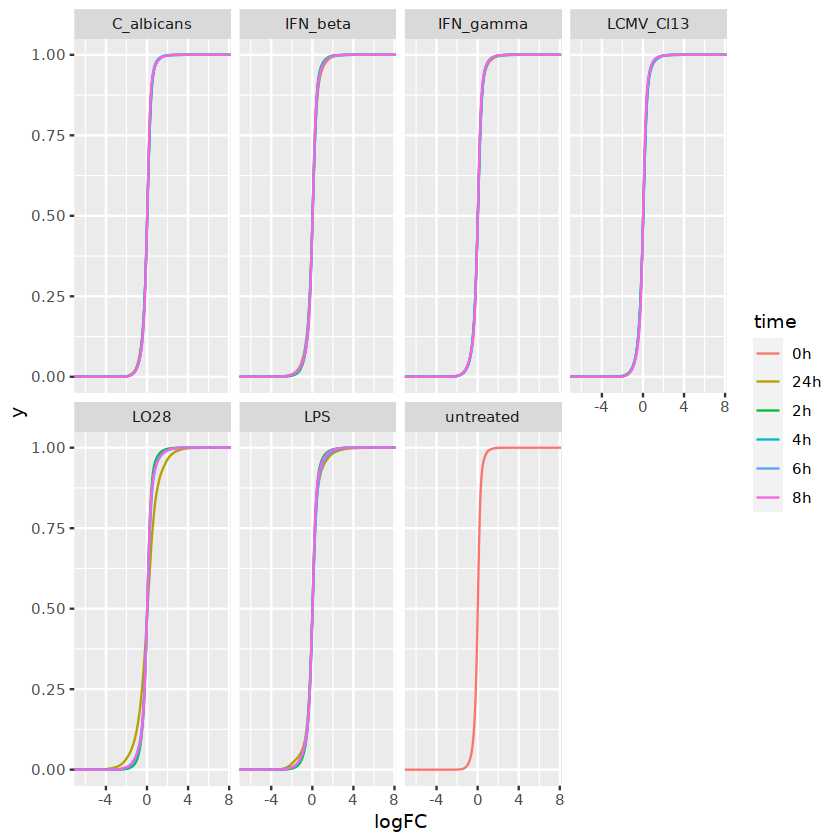

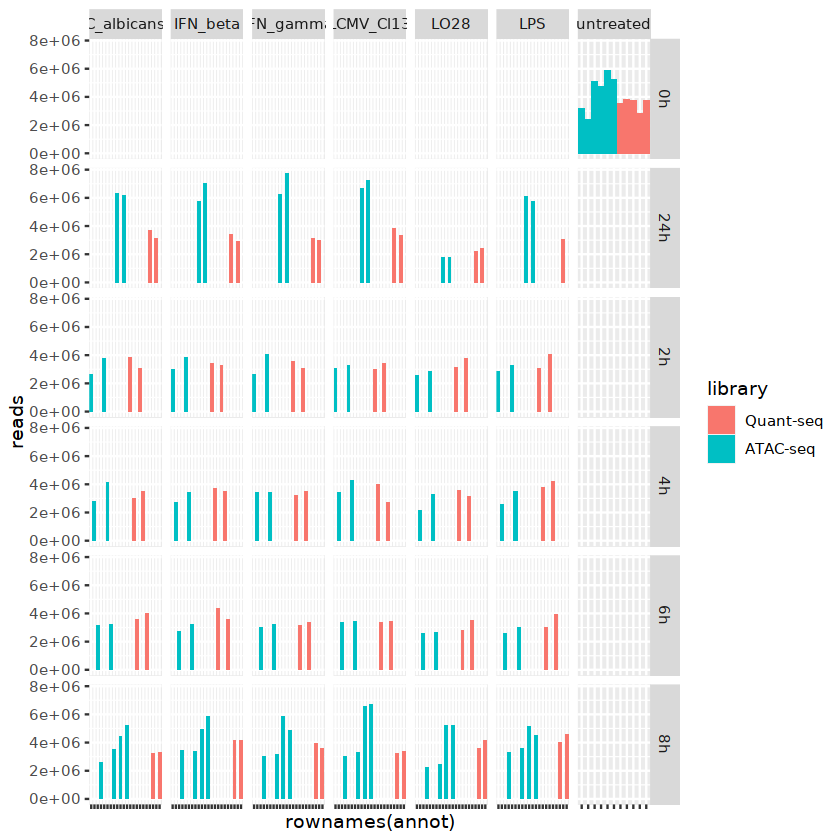

In [60]:
# LFC distribution across treatments and timepoints
ggplot(res, aes(x=logFC, color=time)) + stat_ecdf() + facet_wrap(~treatment, ncol=4)
ggsave(file.path(results_path, 'DEA', "0_LogFCs.pdf"), width=15, height=15)
ggsave(file.path(results_path, 'DEA', "0_LogFCs.jpg"), width=15, height=15)

# reads/counts across treatments and timepoints
annot$reads <- colSums(data)[rownames(annot)]
ggplot(annot, aes(x=rownames(annot), fill=library, y=reads)) + 
  geom_bar(stat="identity")  + facet_grid(time~treatment, scales="free_x") +theme(axis.text.x = element_blank())
ggsave(file.path(results_path, 'DEA',  "0_NrReads.pdf"), width=15, height=15)

Warning message in melt(atac.agg - rna.agg):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(atac.agg - rna.agg). In the next version, this warning will become an error.”


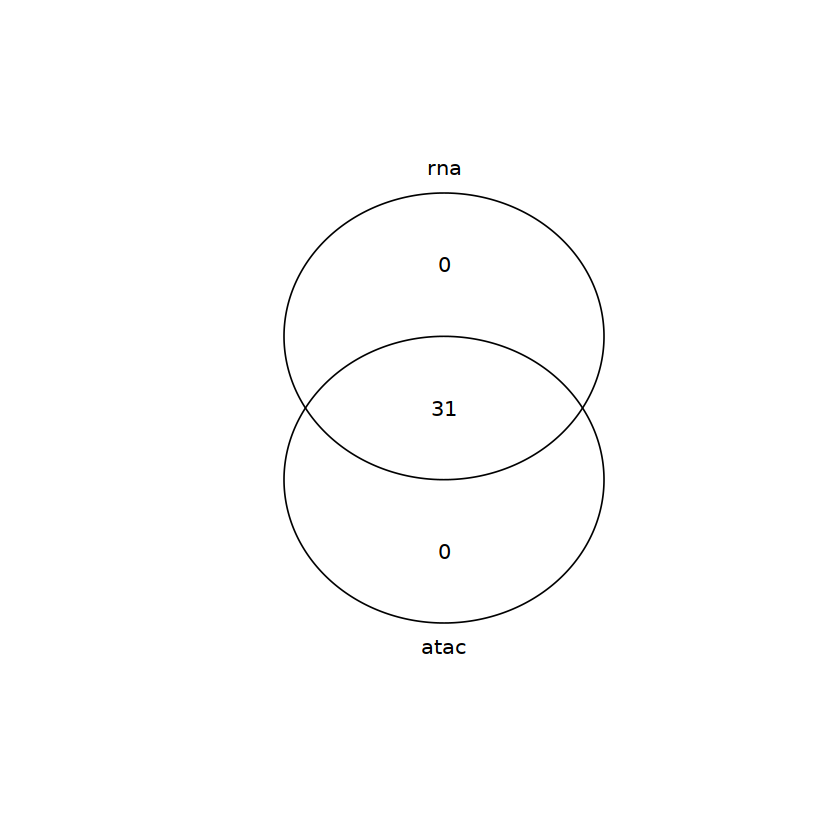

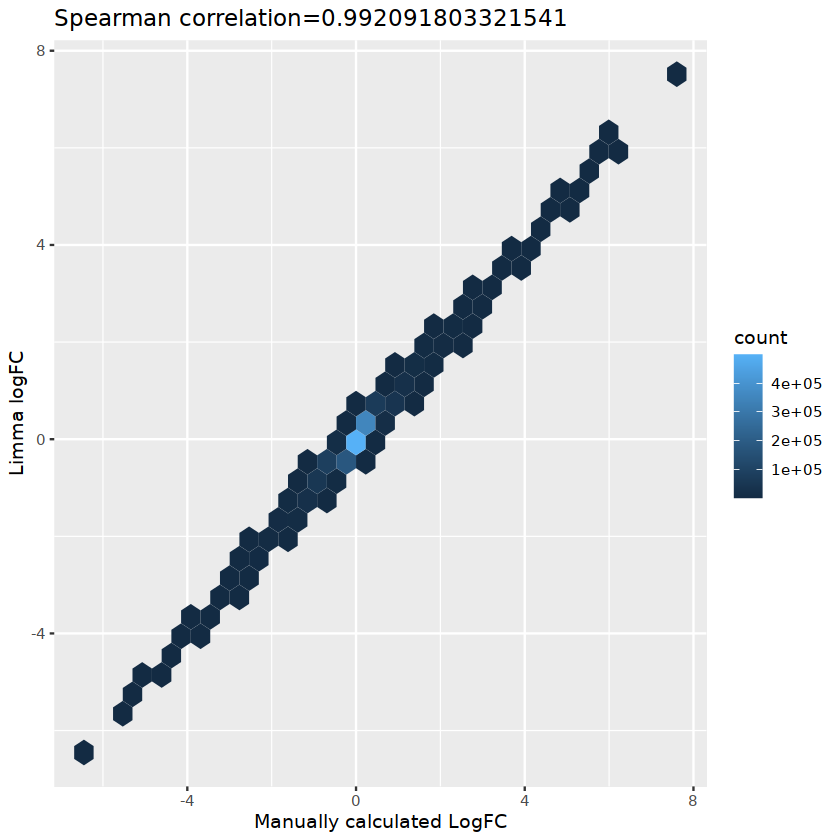

In [61]:
# SANITY CHECK of manually vs limma LFC calculation
atac.aDF <- annot[rownames(annot)[annot$library=='ATAC-seq'],]
rna.aDF <- annot[rownames(annot)[annot$library=='Quant-seq'],]

atac.aDF$sample_name <- rownames(atac.aDF)
rna.aDF$sample_name <- rownames(rna.aDF)

atac.agg <- sapply(with(atac.aDF, split(sample_name, factor(paste0(treatment,'_', time)))), function(x) rowMeans(vMT.norm[, x,drop=F]))
rna.agg <- sapply(with(rna.aDF, split(sample_name, factor(paste0(treatment,'_', time)))), function(x) rowMeans(vMT.norm[,x,drop=F]))
gplots::venn(list(atac=colnames(atac.agg), rna=colnames(rna.agg)))
stopifnot(colnames(atac.agg) == colnames(rna.agg))
pDat <- merge(res,data.table(melt(atac.agg - rna.agg)),by.x=c("group", "rn"), by.y=c("Var2", "Var1"))
ggplot(pDat,
       aes(x=value,y=logFC)) + geom_hex() +
  xlab("Manually calculated LogFC") + ylab("Limma logFC") +
  ggtitle(paste0('Spearman correlation=',cor(pDat$value, pDat$logFC, method="spearman")))
ggsave(file.path(results_path, 'DEA', "SanityCheck_LOGFC.pdf"), width=4, height=4)

Warning message in melt(cMT.mins):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(cMT.mins). In the next version, this warning will become an error.”


0%        25%        50%        75%       100% 
-0.7984773 -0.7353081 -0.6760591  2.4650772 11.7677562

0%  25%  50%  75% 100% 
   0    3    8   73 2757

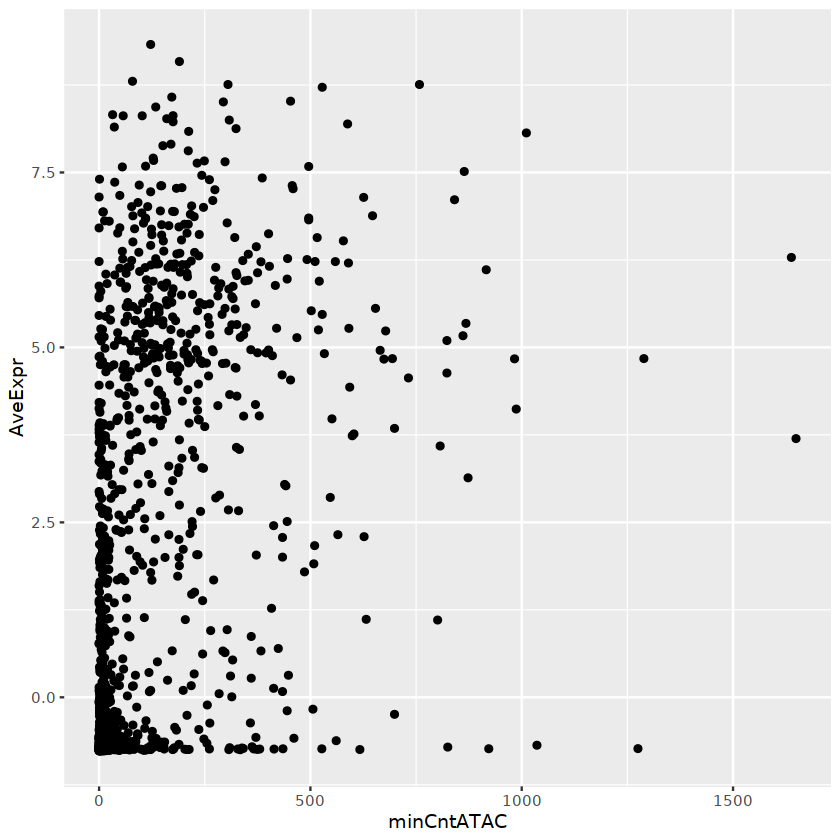

In [62]:
# Analyze minimum counts in ATAC seq
cMT <- data
annot$sample_name <- rownames(annot)

grp.samples <- with(annot[annot$library == "ATAC-seq",], split(sample_name, factor(group)))
cMT.mins <- sapply(grp.samples, function(x) apply(cMT[,x,drop=F],1,min))
cMT.mins <- data.table(melt(cMT.mins))
colnames(cMT.mins)[3] <- "minCntATAC"
res_plot <- merge(res, cMT.mins, by.x=c("rn", "group"), by.y=c("Var1", "Var2"))

ggplot(res_plot[sample(1:nrow(res_plot), 2000),], aes(x=minCntATAC, y=AveExpr)) + geom_point()
ggsave(file.path(results_path, 'DEA', "AveExpr_minCntATAC.pdf"), width=4, height=4)
                   
quantile(res_plot$AveExpr)
quantile(res_plot$minCntATAC)

# filter results & plots

In [63]:
# filter configs
LFC_filter <- 1
AveExpr_filter <- 1 #reason: voom mean/variance plot; before: 0


In [64]:
# filter
# will NOT filter by minCntATAC because also interested in "epigenetic silencing/inhibition"
# how to decide on filter criteria for AveExpr?

res.sig_filtered <- res.sig[(res.sig$AveExpr > AveExpr_filter) & (abs(res.sig$logFC) > LFC_filter) & (res.sig$adj.P.Val < 0.05),]

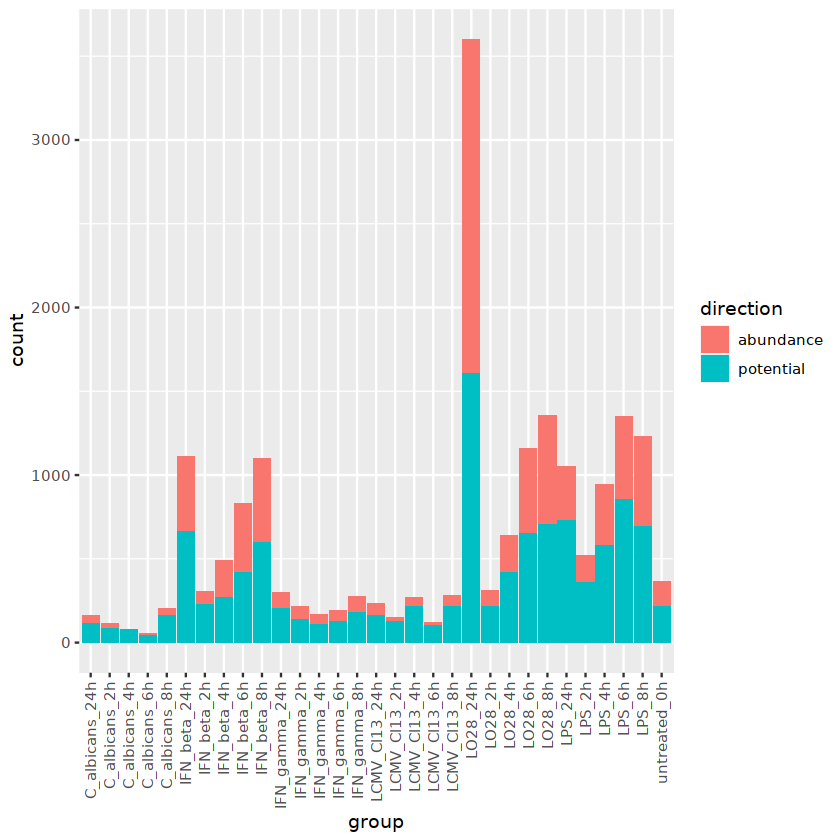

In [65]:
# plot number of significant hits
ggplot(res.sig_filtered, aes(x=group, fill=direction)) + geom_bar() + xRot()
ggsave(file.path(results_path, 'DEA',  "NumberOfHits_filtered.pdf"), w=10,h=5)

In [66]:
# Correlation of log fold changes ALL GENES
logfcMT <- toMT(dt=data.table(res), row="rn", col="group", val="logFC")
cMT <- cor(logfcMT)
diag(cMT) <- NA
cleanDev();
pdf(file.path(results_path, "DEA", "Correlations_logFC.pdf"),w=8,h=8)
pheatmap(cMT)
dev.off()

write.table(cMT, file.path(results_path, "DEA", paste0('DEA_LFC_correltation.csv')) ,sep=",", row.names=TRUE, quote=FALSE)

[1] TRUE

null device 
          1

In [67]:
# Correlation of log fold changes Only significant genes (by adj.pvalue < 0.05)
cMT <- cor(logfcMT[unique(res.sig$rn),])
diag(cMT) <- NA
cleanDev(); pdf(file.path(results_path, "DEA", "Correlations_logFC_Significant.pdf"),w=8,h=8)
pheatmap(cMT)
dev.off()

[1] TRUE

null device 
          1

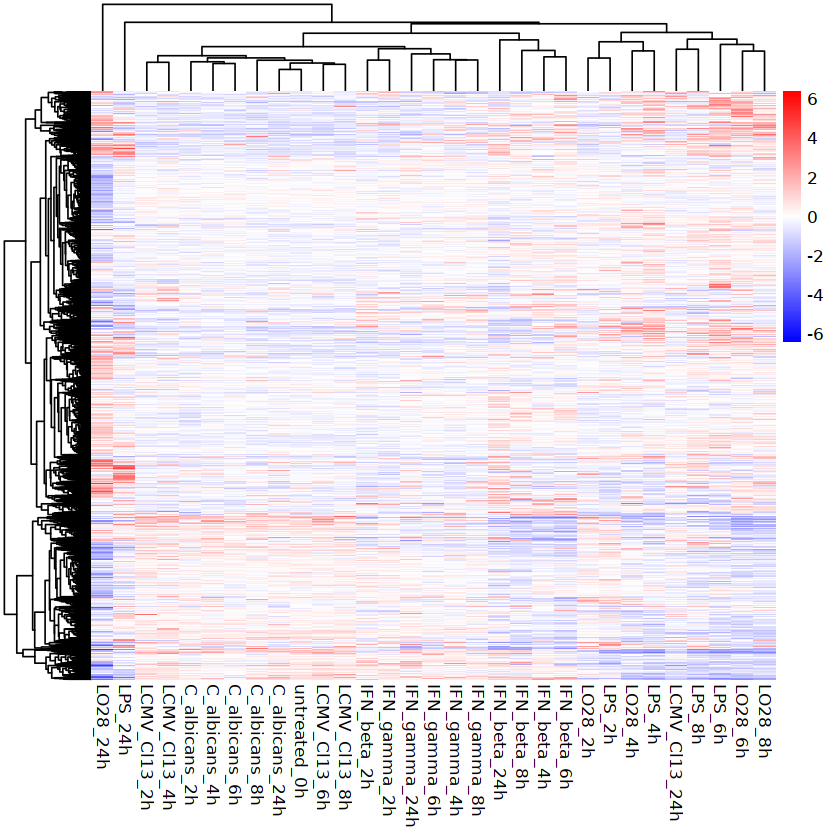

In [68]:
# clustered Heatmap of changes by LFC of significant genes (adj. p value <0.05, abs(LFC)>1, Average expression >0)
# logfcMT <- toMT(dt=res[grepl("_2h$", group)], row="rn", col="group", val="logFC")[unique(res.sig$rn),]

# filter sign. regions by average expression > 0
AveExprMT <- toMT(dt=data.table(res), row="rn", col="group", val="AveExpr")[unique(res.sig$rn),]
# make LFC matrix
logfcMT <- toMT(dt=data.table(res), row="rn", col="group", val="logFC")[rownames(AveExprMT[apply(AveExprMT, 1, max) > AveExpr_filter,]),]
# # filter LFC matrix for regions that at least once have abs(LFC) > 2
logfcMT2 <- logfcMT[apply(abs(logfcMT), 1, max) > LFC_filter,] 

# save filtered LFC table
write.table(logfcMT2, file.path(results_path, "DEA", paste0('DEA_LFC_gene_matrix.csv')) ,sep=",", row.names=TRUE, quote=FALSE)


px <- pheatmap(
  logfcMT2, show_rownames=F,
  breaks=seq(-max(abs(logfcMT)), max(abs(logfcMT)), length.out=200), 
  color=colorRampPalette(c("blue", "white", "red"))(200))

for(cl.n in 4:12){
  clusters <- data.frame(value=cutree(px$tree_row, cl.n))
  clusters$value <- factor(clusters$value)

  outCl <- file.path(results_path, "DEA", paste0("Clusters_HM_", cl.n))
  dir.create(outCl)
    
  cleanDev(); pdf(file.path(outCl, paste0("Clusters_HM_", cl.n, ".pdf")),w=8,h=8)
  px <- pheatmap(logfcMT2, show_rownames=F, 
                 annotation_row=clusters,
                 annotation_colors=list(value=setNames(RColorBrewer::brewer.pal(n=cl.n, name="Paired"), nm=unique(clusters$value))),               
                 breaks=seq(-max(abs(logfcMT)), max(abs(logfcMT)), length.out=200), 
                 color=colorRampPalette(c("blue", "white", "red"))(200))
  dev.off()
  

  genes <- data.table(clusters, keep.rownames=T)
  write.table(genes, file.path(outCl, "Genes.csv"),sep=",", row.names=TRUE, quote=FALSE)                 
}

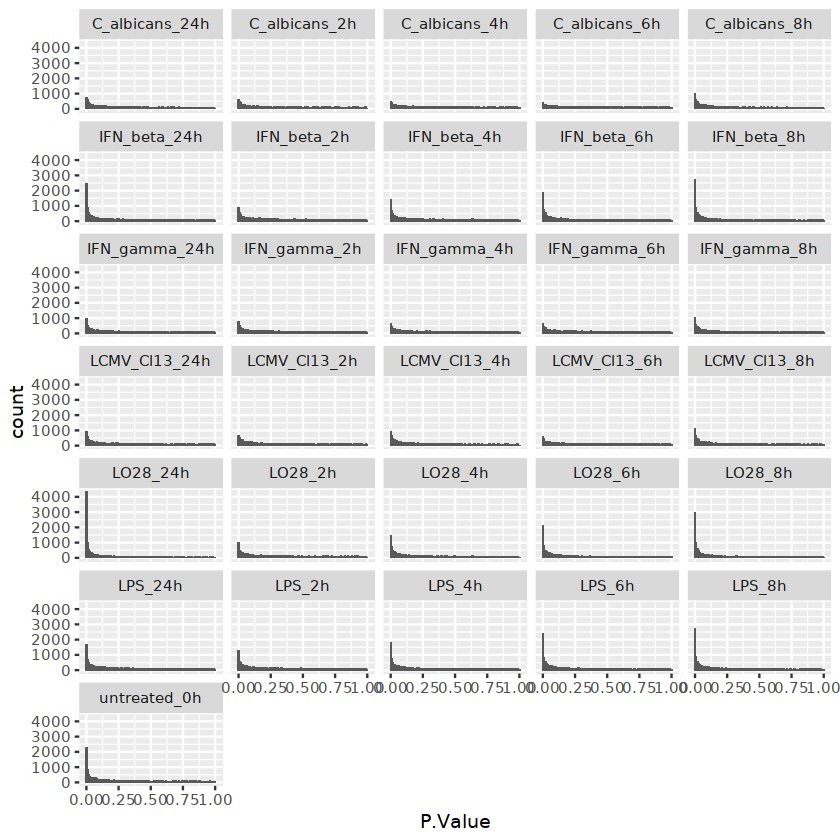

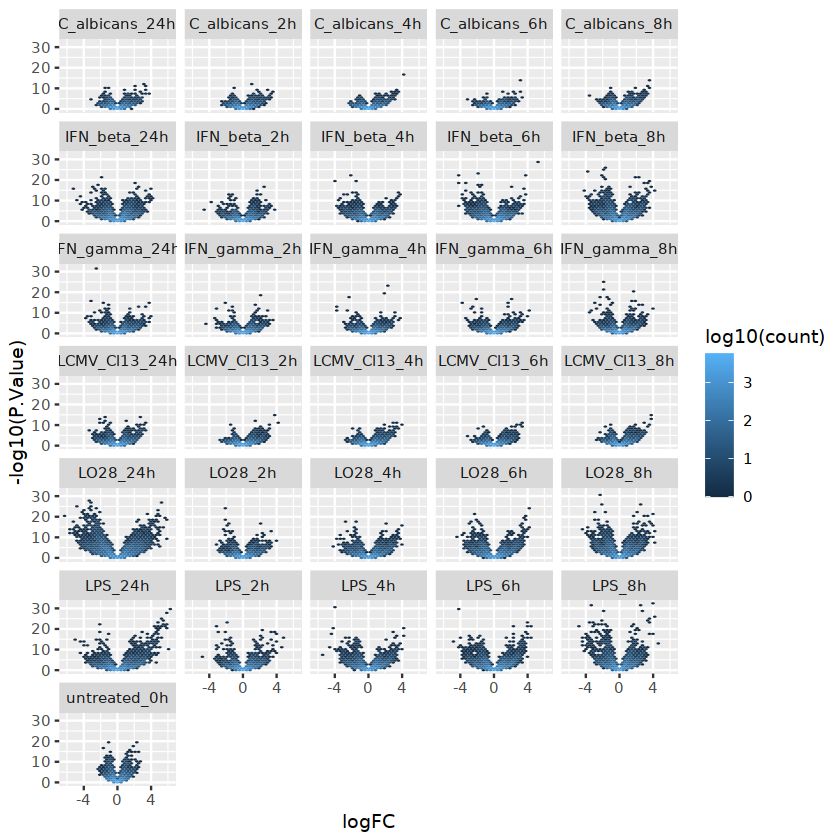

In [69]:
res <- data.table(res)

# pvalue distribution overview
ggplot(res[AveExpr > 0], aes(x=P.Value)) + geom_histogram(bins=100) + facet_wrap(~group, ncol=5)
ggsave(file.path(results_path, "DEA", "PvalueDistribution.pdf"), w=8,h=8)

# volcano plots overview
ggplot(res[AveExpr > 0], aes(x=logFC, y=-log10(P.Value))) + stat_binhex(aes(fill=log10(..count..))) + facet_wrap(~group, ncol=5)
ggsave(file.path(results_path, "DEA", "VolcanoPlots.pdf"), w=8,h=8)